# ML Project Phase 2
*   21100157
*   21100320
*   21100297
*   21100130
*   21100260




# Downloading dataset and unzipping

In [1]:
!gdown --id 1GbfEJ4JnTGthMs4RP5z17BrCQm6YxtEG

Downloading...
From: https://drive.google.com/uc?id=1GbfEJ4JnTGthMs4RP5z17BrCQm6YxtEG
To: /content/LUMS_FALL2020_PROJECT_DATA.zip
802MB [00:05, 144MB/s]


In [2]:
!unzip "LUMS_FALL2020_PROJECT_DATA.zip" -d "ML Project Phase 2/"

Archive:  LUMS_FALL2020_PROJECT_DATA.zip
   creating: ML Project Phase 2/Gender_Recognition/Test/
   creating: ML Project Phase 2/Gender_Recognition/Test/SPK083_M/
  inflating: ML Project Phase 2/Gender_Recognition/Test/SPK083_M/1.wav  
  inflating: ML Project Phase 2/Gender_Recognition/Test/SPK083_M/10.wav  
  inflating: ML Project Phase 2/Gender_Recognition/Test/SPK083_M/2.wav  
  inflating: ML Project Phase 2/Gender_Recognition/Test/SPK083_M/3.wav  
  inflating: ML Project Phase 2/Gender_Recognition/Test/SPK083_M/4.wav  
  inflating: ML Project Phase 2/Gender_Recognition/Test/SPK083_M/5.wav  
  inflating: ML Project Phase 2/Gender_Recognition/Test/SPK083_M/6.wav  
  inflating: ML Project Phase 2/Gender_Recognition/Test/SPK083_M/7.wav  
  inflating: ML Project Phase 2/Gender_Recognition/Test/SPK083_M/8.wav  
  inflating: ML Project Phase 2/Gender_Recognition/Test/SPK083_M/9.wav  
   creating: ML Project Phase 2/Gender_Recognition/Test/SPK084_M/
  inflating: ML Project Phase 2/Gender_

# Imports

In [3]:
!pip install python_speech_features


import string
import numpy as np
import seaborn as sns
import os
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import python_speech_features as mfcc
from scipy.io.wavfile import read
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=89ae32e29779ae551d2ed67d7061d17ebe4869b44e3ede3f2f6128819ab311e8
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


# Global helper functions

In [4]:
"""
returns mfcc vector (features) of wav file
features are 13 dimentional
"""

def get_MFCC(audio, sr):
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = True)
    return np.mean(features, axis=0)

In [5]:
"""
Takes path of the directory i.e. path to train, test, or valid directory and returns features and labels in that directory as lists
"type" parameter in function is just to distinguish whether file reading is for gender or speaker recognition
"""

def readFiles(path, type):
  labels = [] # for speaker recognition, labels are speaker id i.e. SPK001 and for gender recognition, labels are gender i.e. male (M) or female (F)
  features = [] # wav files represented in MFCC vector
  subdirs = os.listdir(path) # this will return names of all the subdirectories in "path". Inside each of these subdirectories are the wav files that we will read
  for dir in subdirs: # iterating over all the subdirectories names present in "path"
    dirName = dir # will use to extract features
    dir = dir + "/"
    pathToRead = os.path.join(path, dir) # Now this path contains the wav files to be read as MFCCs vector
    wavFiles = os.listdir(pathToRead) # list of all the wav files in the current subdirectory of "path"
    if type == "speaker":
      label = dirName.split("_")[0] # e.g. if "SPK017_F" then splitting gives ["SPK017", "F"] and 0th index would be then label
    else:
      label = dirName.split("_")[1] # e.g. if "SPK017_F" then splitting gives ["SPK017", "F"] and 1st index would be then label
    for f in wavFiles: # iterating over the wav files in the current subdirectory of "path"
      currentWav = os.path.join(pathToRead, f) # current wav file to be read in that particular subdirectory of "path"
      sr, audio = read(currentWav)
      mfccVector = get_MFCC(audio, sr)
      labels.append(label)
      features.append(mfccVector) # this does not include bias right now
  return features, labels

# Multinomial logistic regression (Implementation)

## Softmax

In [6]:
"""
returns probabilities between 0 and 1 for each class
z is the vector containing class values which are to be squashed between 0 and 1 -> 2 values for gender recognition and 142 values for speaker recognition
"""

def softmax(z):
  exponent = np.exp(z)
  return exponent / exponent.sum()

## Hypothesis

In [7]:
"""
w is our theta basically. See slide number 5 of "Logistic Regression Softmax" lecture from slides
shape of w : k x m where k represents number of classes and m are the number of features -> 2 x 14 for gender recognition and 142 x 14 for speaker recognition
shape of x : m x 1 where m is the total number of features -> 14 x 1 for gender and speaker recognition both
computes : wx + b where b is the bias term (already appended in feature vector)
returns vector of shape : k x 1 where k is the number of classes -> 2 x 1 for gender recognition and 142 x1 for speaker recognition
"""

def hypothesis(w, x):
    return (np.matmul(w, x))

## Cross-entropy loss

In [8]:
"""
yhat is the vector of probabilities that is obtained through softmax
y are the one hot encoded labels
returns the total cost
Slide number 7 of "Logistic Regression Softmax" lecture from slides
"""

def crossEntropyLoss(yhat, y):
  cost = y*np.log(yhat)
  return -1/y.shape[0]*np.sum(cost)

## Batch gradient descent

In [9]:
"""
x -> training data
y -> train labels (one hot encoded)
n_epoch -> number of iterations
alpha -> learning rate
validx -> validation data set features
validy -> validation data set labels (one hot encoded)
Slide 4 of lecture "Logistic regression gradient descent"
"""

def MultinomialGradientDescent(x, y, validx, validy, n_epoch, alpha):
    print("Running for alpha = ", alpha, " and epochs = ", n_epoch)
    print('')
    epochs_done = 0
    m = x.shape[0] # total number of samples
    J = list() # costs
    w = np.ones(shape=(y.shape[1], x.shape[1])) # parameters to be learned for each class. shape : k x m where k is the number of classes and m is the total features
    trainLoss = []
    validLoss = []

    for epoch in range(n_epoch):

        probabilities = []
        # this is basically calculating softmax(hypothesis(wx + b))
        for i in range(len(x)): # we can't vectorize this since shapes are different. we need to pass individual feature to hypothesis function and squash values between 0 and 1 using softmax
            hyp = hypothesis(w, x[i])
            prob = softmax(hyp)
            probabilities.append(prob)

        differences = probabilities - y # softmax(hypothesis(wx + b)) - train labels (one-hot encoded)
        
        lst = []

        # this is basically multiplying with the xj term
        for i in range(m):
            lst.append(differences[i].reshape((-1, 1)) * x[i].reshape((1, -1))) # shape of each item in differences vector is 2 x 1 and shape of each item in train data is 14 x 1 hence reshaped t0 1 x 14
            
        summation = np.sum(lst, axis=0) # summing up over all samples
            
        # updating parameters
        grad = (1.0 / m) * summation
        temp = w - alpha * grad
        w = temp
        
        # computing cross entropy loss (for multinomial) on TRAIN set
        probabilities = [] # calculate new probs with updated parameters
        for i in range(len(x)):
            hyp = hypothesis(w, x[i])
            prob = softmax(hyp)
            probabilities.append(prob)

        probabilities = np.array(probabilities)
        loss = crossEntropyLoss(probabilities, y)
        trainLoss.append(loss) # append to list



        #computing cross entropy loss (for multinomial) on VALIDATION set
        probabilities = [] # calculate new probs with updated parameters
        for i in range(len(validx)):
            hyp = hypothesis(w, validx[i])
            prob = softmax(hyp)
            probabilities.append(prob)

        probabilities = np.array(probabilities)
        loss = crossEntropyLoss(probabilities, validy)
        validLoss.append(loss) # append to list



        epochs_done += 1

        if (epochs_done % 100 == 0):
            print(epochs_done, " epochs completed")
            
        if (epochs_done == n_epoch):
            print(n_epoch, " epochs completed")

    print("")
    print("Batch gradient descent completed for alpha = ", alpha, " and epochs = ", n_epoch)
    print('')
    print('-----------------------------------------------------------')
    print('')
        
    return w, trainLoss, validLoss

## Prediction function

In [10]:
"""
w is our theta basically. See slide number 5 of "Logistic Regression Softmax" lecture from slides
shape of w : k x m where k represents number of classes and m are the number of features -> 2 x 14 for gender recognition and 142 x 14 for speaker recognition
shape of x : m x 1 where m is the total number of features -> 14 x 1 for gender and speaker recognition both
computes : prediction given the learned parameters and a test sample
returns : argmax of the greater of all probabilities -> the argmax would be the label i.e male and female in case of gender recognition and id in case of speaker recognition
"""

def predict(w, x):
  hyp = hypothesis(w, x)
  probs = softmax(hyp)
  return np.argmax(probs)

## Evaluation function

In [11]:
"""
This function takes the trained weights, test Features and the encoding values (one-hot labels)
Prints: classification accuracy, macro-average, and confusion matrix

"""

def evaluate(w, testFeatures, encodings):
  # evaluating on test set
    preds = []
    for i in range(len(testFeatures)):
        pred = predict(w, testFeatures[i])
        preds.append(pred)
    preds = np.array(preds)

    y_true = []
    
    for i in range(len(encodings)):
        y_true.append(np.argmax(encodings[i]))

    accuracy = accuracy_score(y_true, preds)
    report = classification_report(y_true, preds, output_dict=True)
    confusionmatrix = confusion_matrix(y_true, preds)

    print('Accuracy metrics on test set are as follows')
    print('')
    print('Accuracy: ', round(accuracy * 100, 2), '%')
    print('Macro-precision: ', round(report['macro avg']['precision'] * 100, 2), '%')
    print('Macro-recall: ', round(report['macro avg']['recall'] * 100, 2), '%')
    print('Macro-f1: ', round(report['macro avg']['f1-score'] * 100, 2), '%')
    print('')
    print('Confusion matrix on test set')
    if (confusionmatrix.shape[0] > 5):
      plt.figure(figsize= (40,35))
    else:
      plt.figure(figsize=(8,5))
    ax = sns.heatmap(confusionmatrix,annot=True,fmt=".0f")
    title = "Confusion matrix"
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')

# Gender recognition

## Reading gender recognition dataset and feature extraction

In [12]:
genderTrainPath = "ML Project Phase 2/Gender_Recognition/Train/" # path containing folders of gender train data
genderTestPath = "ML Project Phase 2/Gender_Recognition/Test/" # path containing folders of gender test data
genderValidPath = "ML Project Phase 2/Gender_Recognition/Valid/" # path containing folders of gender validation data

In [13]:
trainFeatures, trainLabels = readFiles(genderTrainPath, "gender") # reading train data (features) and labels 
testFeatures, testLabels = readFiles(genderTestPath, "gender") # reading test data (features) and labels
validFeatures, validLabels = readFiles(genderValidPath, "gender") # reading validation data (features) and labels

In [14]:
# visualizing length of lists to verify all files have been read
print(len(trainFeatures))
print(len(testFeatures))
print(len(validFeatures))
print('')
print(len(trainLabels))
print(len(testLabels))
print(len(validLabels))

1080
170
170

1080
170
170


In [15]:
# adding bias (x0 = 1) term
for i in range(len(trainFeatures)):
  # arr, index-obj, values, axis
  trainFeatures[i] = np.insert(trainFeatures[i], 0, 1.0, axis=0) # append 1 for bias term at the beginning of each numpy (feature) array

for i in range(len(testFeatures)):
  testFeatures[i] = np.insert(testFeatures[i], 0, 1.0, axis=0) # append 1.0 for bias term at the beginning of each numpy (feature) array

for i in range(len(validFeatures)):
  validFeatures[i] = np.insert(validFeatures[i], 0, 1.0, axis=0) # append 1.0 for bias term at the beginning of each numpy (feature) array

In [16]:
# one hot encoding the class labels
trainLabelsEncoded, testLabelsEncoded, validLabelsEncoded = [], [], []

for i in trainLabels:
  if i == 'F':
    trainLabelsEncoded.append([0, 1])
  else:
    trainLabelsEncoded.append([1, 0]) # M

for i in testLabels:
  if i == 'F':
    testLabelsEncoded.append([0, 1])
  else:
    testLabelsEncoded.append([1, 0])

for i in validLabels:
  if i == 'F':
    validLabelsEncoded.append([0, 1])
  else:
    validLabelsEncoded.append([1, 0])

# converting to numpy arrays
trainLabelsEncoded = np.array(trainLabelsEncoded)
testLabelsEncoded = np.array(testLabelsEncoded)
validLabelsEncoded = np.array(validLabelsEncoded)

In [17]:
# converting to numpy arrays
trainFeatures = np.array(trainFeatures)
testFeatures = np.array(testFeatures)
validFeatures = np.array(validFeatures)

trainLabels = np.array(trainLabels)
testLabels = np.array(testLabels)
validLabels = np.array(validLabels)

# reshaping labels 
trainLabels = trainLabels.reshape((len(trainLabels), -1))
testLabels = testLabels.reshape((len(testLabels), -1))
validLabels = validLabels.reshape((len(validLabels), -1))

# visualizing shapes
print('Feature shapes')
print(trainFeatures.shape)
print(testFeatures.shape)
print(validFeatures.shape)
print('')
print('Labels shapes')
print(trainLabels.shape)
print(testLabels.shape)
print(validLabels.shape)
print('')
print('One hot encodings shapes')
print(trainLabelsEncoded.shape)
print(testLabelsEncoded.shape)
print(validLabelsEncoded.shape)

Feature shapes
(1080, 14)
(170, 14)
(170, 14)

Labels shapes
(1080, 1)
(170, 1)
(170, 1)

One hot encodings shapes
(1080, 2)
(170, 2)
(170, 2)


#### Now training on train data and validating on validation set using multiple alpha values and epochs to find optimal hyper-parameters and reporting plots for train and validation losses against number of iterations

In [18]:
def print_results(epochs, alpha, w, trainLoss, validLoss, validFeatures, validLabelsEncoded):
    # plotting
    iters = [i for i in range(1, epochs + 1, 1)]
    plt.plot(iters, trainLoss, 'r', label='Training loss')
    plt.plot(iters, validLoss, 'b', label='Validation loss')
    plt.xlabel('Number of iterations')
    plt.ylabel('Training/Validation loss')
    plt.title('Training and Validation losses against Number of iterations for alpha = ' + str(alpha) + ' and iterations = ' + str(epochs))
    plt.legend()
    plt.show()

    preds = []
    for i in range(len(validFeatures)):
        pred = predict(w, validFeatures[i])
        preds.append(pred)
    preds = np.array(preds)

    y_true = []
    
    for i in range(len(validLabelsEncoded)):
        y_true.append(np.argmax(validLabelsEncoded[i]))

    accuracy = accuracy_score(y_true, preds)
    report = classification_report(y_true, preds, output_dict=True)
    print('Accuracy metrics on validation set are as follows')
    print('')
    print('Accuracy: ', round(accuracy * 100, 2), '%')
    print('Macro-precision: ', round(report['macro avg']['precision'] * 100, 2), '%')
    print('Macro-recall: ', round(report['macro avg']['recall'] * 100, 2), '%')
    print('Macro-f1: ', round(report['macro avg']['f1-score'] * 100, 2), '%')
    print('')


In [19]:
"""
Just a helper function to train, validate and report plots. Validation set is used for hyperparameter tuning
Returns: Weights from trained data

"""

def genderHelper(epochs, alpha):

    # training and validation
    w, trainLoss, validLoss = MultinomialGradientDescent(trainFeatures, trainLabelsEncoded, validFeatures, validLabelsEncoded, epochs, alpha)
    print_results(epochs, alpha, w, trainLoss, validLoss,validFeatures,validLabelsEncoded)
    return w

### HyperParameter Tuning



Here, we will use different alpha and epoch combinations to tune the hyperparameters. 

Evaluation will be performed on the validation set to determine the best set of parameters to use for the test set

Running for alpha =  1  and epochs =  100

100  epochs completed
100  epochs completed

Batch gradient descent completed for alpha =  1  and epochs =  100

-----------------------------------------------------------



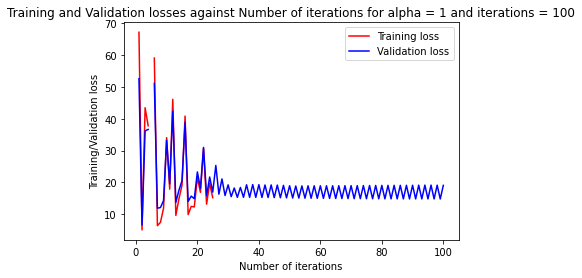

Accuracy metrics on validation set are as follows

Accuracy:  78.82 %
Macro-precision:  74.69 %
Macro-recall:  57.6 %
Macro-f1:  57.79 %



In [20]:
w1 = genderHelper(100,1)

Running for alpha =  0.1  and epochs =  100

100  epochs completed
100  epochs completed

Batch gradient descent completed for alpha =  0.1  and epochs =  100

-----------------------------------------------------------



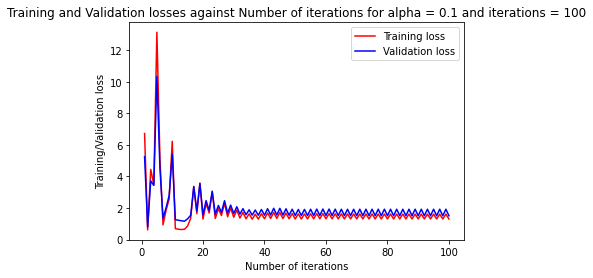

Accuracy metrics on validation set are as follows

Accuracy:  85.88 %
Macro-precision:  80.15 %
Macro-recall:  85.58 %
Macro-f1:  82.12 %



In [21]:
w2 = genderHelper(100, 0.1)

Running for alpha =  0.01  and epochs =  300

100  epochs completed
200  epochs completed
300  epochs completed
300  epochs completed

Batch gradient descent completed for alpha =  0.01  and epochs =  300

-----------------------------------------------------------



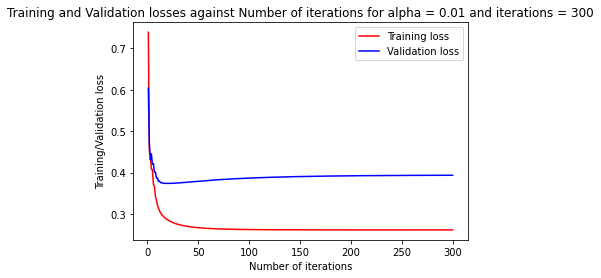

Accuracy metrics on validation set are as follows

Accuracy:  80.0 %
Macro-precision:  72.26 %
Macro-recall:  67.02 %
Macro-f1:  68.75 %



In [22]:
w3 = genderHelper(300,0.01)

Running for alpha =  0.001  and epochs =  500

100  epochs completed
200  epochs completed
300  epochs completed
400  epochs completed
500  epochs completed
500  epochs completed

Batch gradient descent completed for alpha =  0.001  and epochs =  500

-----------------------------------------------------------



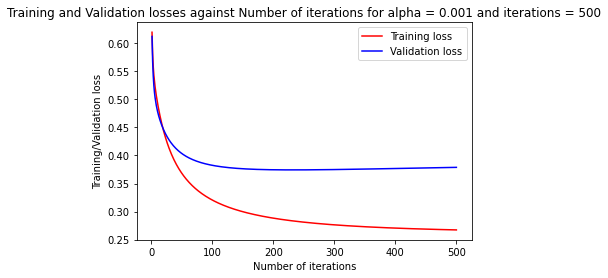

Accuracy metrics on validation set are as follows

Accuracy:  79.41 %
Macro-precision:  71.24 %
Macro-recall:  65.77 %
Macro-f1:  67.47 %



In [23]:
w4 = genderHelper(500,0.001)

### Evaluation on Test Set

Since the best performing alpha value in hyperparameter tuning was alpha = 0.1, we will use the weights from that set for the test dataset

Accuracy metrics on test set are as follows

Accuracy:  84.71 %
Macro-precision:  79.47 %
Macro-recall:  87.4 %
Macro-f1:  81.58 %

Confusion matrix on test set


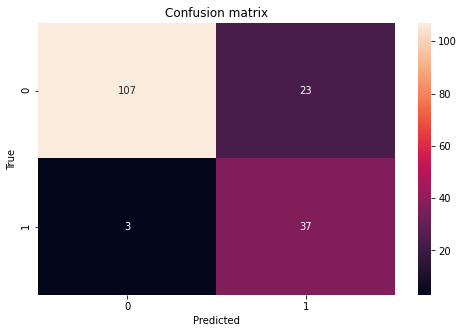

In [24]:
evaluate(w2,testFeatures,testLabelsEncoded)

# Speaker recognition

## Reading speaker recognition dataset and feature extraction

In [25]:
# paths
speakerTrainPath = "ML Project Phase 2/Speaker_Recognition/Train/" # path containing folders of speaker train data
speakerTestPath = "ML Project Phase 2/Speaker_Recognition/Test/" # path containing folders of speaker test data
speakerValidPath = "ML Project Phase 2/Speaker_Recognition/Valid/" # path containing folders of speaker validation data

In [26]:
trainFeatures, trainLabels = readFiles(speakerTrainPath, "speaker") # reading train data (features) and labels 
testFeatures, testLabels = readFiles(speakerTestPath, "speaker") # reading test data (features) and labels
validFeatures, validLabels = readFiles(speakerValidPath, "speaker") # reading validation data (features) and labels

In [27]:
# visualizing length of lists to verify all files have been read
print(len(trainFeatures))
print(len(testFeatures))
print(len(validFeatures))
print('')
print(len(trainLabels))
print(len(testLabels))
print(len(validLabels))

852
284
284

852
284
284


In [28]:
# adding bias (x0 = 1) term
for i in range(len(trainFeatures)):
  trainFeatures[i] = np.insert(trainFeatures[i], 0, 1.0, axis=0) # append 1 for bias term at the beginning of each numpy (feature) array

for i in range(len(testFeatures)):
  testFeatures[i] = np.insert(testFeatures[i], 0, 1.0, axis=0) # append 1 for bias term at the beginning of each numpy (feature) array

for i in range(len(validFeatures)):
  validFeatures[i] = np.insert(validFeatures[i], 0, 1.0, axis=0) # append 1 for bias term at the beginning of each numpy (feature) array

In [29]:
# one hot encoding the class labels
"""
Function to one hot encode the speaker labels
labels -> train, test, or valid labels
returns : list of one hot encodings
"""

#e.g. SPK112_M
# index 3-5:  112, stored at 111 (index-1)
# 142 classes

def hotEncodeSpeaker(labels):
  encoded = []
  for i in range(len(labels)):
    if labels[i][3:5] == '00': # e.g if ids are 001, 002, etc
      id = labels[i][-1]
      lst = [0] * 142
      lst[int(id) - 1] = 1
      encoded.append(lst)
    elif labels[i][3:4] == '0' and labels[i][4:5] != '0': # e.g if ids are 011, 022, etc
      id = labels[i][4:6]
      lst = [0] * 142
      lst[int(id) - 1] = 1
      encoded.append(lst)
    elif labels[i][3:4] != '0': # e.g if ids are 129, 112, etc
      id = labels[i][3:6]
      lst = [0] * 142
      lst[int(id) - 1] = 1
      encoded.append(lst)
  return encoded

# encoding now
trainLabelsEncoded, testLabelsEncoded, validLabelsEncoded = [], [], []
trainLabelsEncoded = hotEncodeSpeaker(trainLabels)
testLabelsEncoded = hotEncodeSpeaker(testLabels)
validLabelsEncoded = hotEncodeSpeaker(validLabels)

# converting to numpy arrays
trainLabelsEncoded = np.array(trainLabelsEncoded)
testLabelsEncoded = np.array(testLabelsEncoded)
validLabelsEncoded = np.array(validLabelsEncoded)

In [30]:
# converting to numpy arrays
trainFeatures = np.array(trainFeatures)
testFeatures = np.array(testFeatures)
validFeatures = np.array(validFeatures)

trainLabels = np.array(trainLabels)
testLabels = np.array(testLabels)
validLabels = np.array(validLabels)

# reshaping labels 
trainLabels = trainLabels.reshape((len(trainLabels), -1))
testLabels = testLabels.reshape((len(testLabels), -1))
validLabels = validLabels.reshape((len(validLabels), -1))

# visualizing shapes
print('Feature shapes')
print(trainFeatures.shape)
print(testFeatures.shape)
print(validFeatures.shape)
print('')
print('Labels shapes')
print(trainLabels.shape)
print(testLabels.shape)
print(validLabels.shape)
print('')
print('One hot encodings shapes')
print(trainLabelsEncoded.shape)
print(testLabelsEncoded.shape)
print(validLabelsEncoded.shape)

Feature shapes
(852, 14)
(284, 14)
(284, 14)

Labels shapes
(852, 1)
(284, 1)
(284, 1)

One hot encodings shapes
(852, 142)
(284, 142)
(284, 142)


#### Now training on train data and validating on validation set using multiple alpha values and epochs to find optimal hyper-parameters and reporting plots for train and validation losses against number of iterations

In [31]:
"""
Just a helper function to train, validate and report plots and finally evaluate on test set

"""

def speakerHelper(epochs, alpha):
    # training and validation
    w, trainLoss, validLoss = MultinomialGradientDescent(trainFeatures, trainLabelsEncoded, validFeatures, validLabelsEncoded, epochs, alpha)
    print_results(epochs, alpha, w, trainLoss, validLoss,validFeatures,validLabelsEncoded)
    return w

### HyperParameter Tuning


Here, we will use different alpha and epoch combinations to tune the hyperparameters. 

Evaluation will be performed on the validation set to determine the best set of parameters to use for the test set

Running for alpha =  1  and epochs =  100

100  epochs completed
100  epochs completed

Batch gradient descent completed for alpha =  1  and epochs =  100

-----------------------------------------------------------



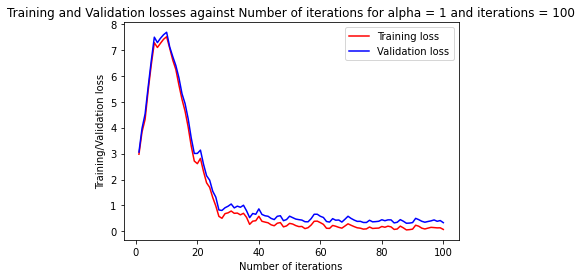

Accuracy metrics on validation set are as follows

Accuracy:  91.2 %
Macro-precision:  91.95 %
Macro-recall:  91.2 %
Macro-f1:  90.14 %



In [32]:
w1 = speakerHelper(100, 1)

Running for alpha =  0.1  and epochs =  300

100  epochs completed
200  epochs completed
300  epochs completed
300  epochs completed

Batch gradient descent completed for alpha =  0.1  and epochs =  300

-----------------------------------------------------------



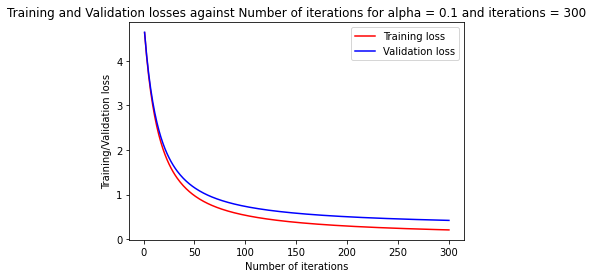

Accuracy metrics on validation set are as follows

Accuracy:  93.66 %
Macro-precision:  95.47 %
Macro-recall:  93.66 %
Macro-f1:  93.17 %



In [33]:
w2 = speakerHelper(300, 0.1)

Running for alpha =  0.01  and epochs =  1500

100  epochs completed
200  epochs completed
300  epochs completed
400  epochs completed
500  epochs completed
600  epochs completed
700  epochs completed
800  epochs completed
900  epochs completed
1000  epochs completed
1100  epochs completed
1200  epochs completed
1300  epochs completed
1400  epochs completed
1500  epochs completed
1500  epochs completed

Batch gradient descent completed for alpha =  0.01  and epochs =  1500

-----------------------------------------------------------



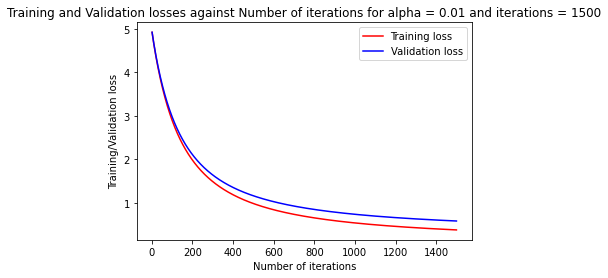

Accuracy metrics on validation set are as follows

Accuracy:  94.37 %
Macro-precision:  95.77 %
Macro-recall:  94.37 %
Macro-f1:  93.85 %



In [34]:
w3 = speakerHelper(1500,0.01)

### Evaluation on Test Set

Since the best performing alpha value in hyperparameter tuning was alpha = 0.01, we will use the weights from that set for the test dataset.
This gives an accuracy of 95.77% and Macro-F1 of 95.49.


Accuracy metrics on test set are as follows

Accuracy:  95.77 %
Macro-precision:  96.6 %
Macro-recall:  95.77 %
Macro-f1:  95.49 %

Confusion matrix on test set


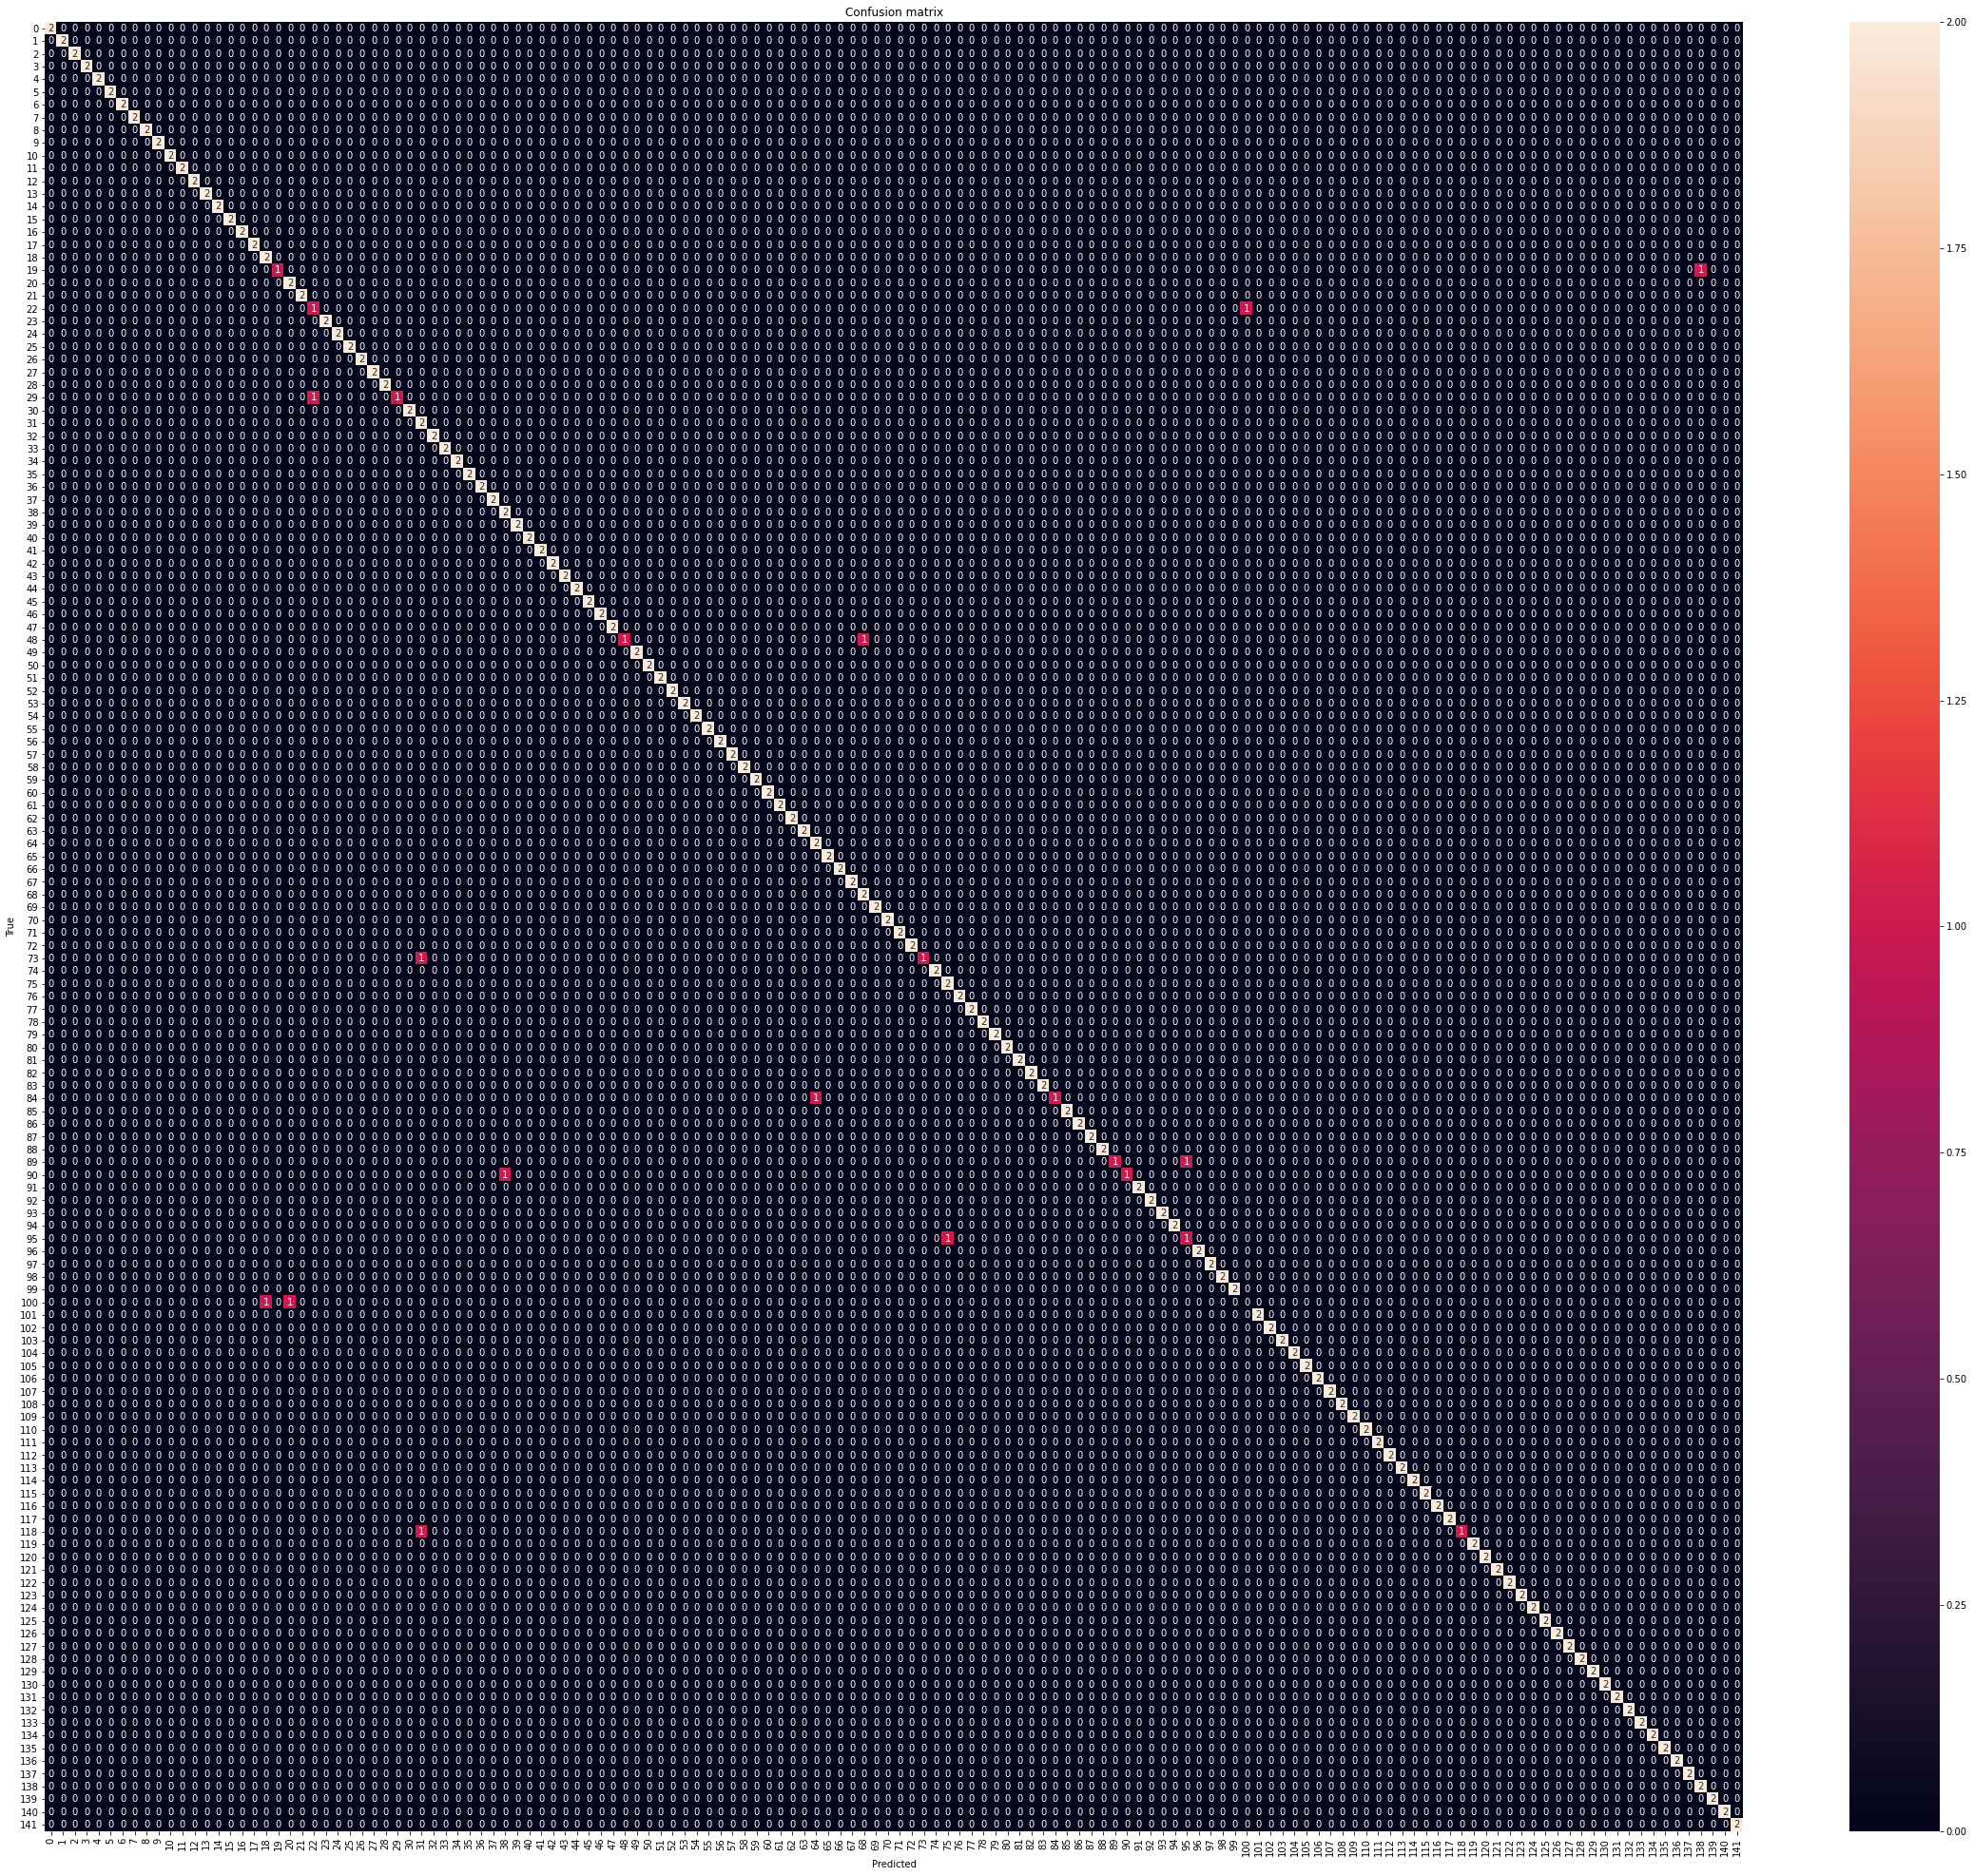

In [35]:
evaluate(w3,testFeatures,testLabelsEncoded)